In [2]:
import joblib
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import argparse
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error
import math
import wandb

from wandb.integration.keras.callbacks import WandbMetricsLogger, WandbModelCheckpoint



pca = joblib.load("../Models/pca/pca-model.joblib")
pca_scaler = joblib.load("../Models/pca/pca_scaler.joblib")

data = np.load("../Data/LPS/classifier_lps_data.npy")
Y = np.load("../Data/LPS/classifier_lps_labels.npy")
print(data.shape)

(3315, 67499)


In [3]:
X = pca_scaler.fit_transform(data)
X = pca.fit_transform(X)
print(X.shape)

(3315, 200)


In [4]:
# wandb.init(
#     project="PCAClassifier",
#     config={
#         "hidden_size": 64,
#         "activation": "relu",
#         "dropout": 0.5,
#         "output_activation": "softmax",
#         "optimizer": "adam",
#         "loss": "sparse_categorical_crossentropy",
#         "metric": "accuracy",
#         "epochs": 50,
#         "batch_size": 32,
#         "learning_rate": 0.001
#     }
# )

# config = wandb.config

In [ ]:
class MLPClassifier(tf.keras.Model):
    def __init__(self, num_classes=2, hidden_size=64, dropout_rate=0.5):
        super().__init__()
        self.hidden = layers.Dense(hidden_size, activation='relu')
        self.dropout = layers.Dropout(dropout_rate)
        self.classifier = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.hidden(inputs)
        x = self.dropout(x)
        return self.classifier(x)

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42, stratify=y_temp)
print(f'Training data shape: {X_train.shape}')
print(f'Val data shape: {X_val.shape}')
print(f'Test data shape: {X_test.shape}')
print("NaN in training data:", np.isnan(X).any())
print("Input range:", np.min(X), "to", np.max(X))

Training data shape: (2320, 200)
Val data shape: (331, 200)
Test data shape: (664, 200)
NaN in training data: False
Input range: -234.84474 to 573.4868


In [7]:
input_dim = X_train.shape[1]
model = MLPClassifier(input_dim=input_dim,hidden_size=64)

2025-10-31 18:36:34.312312: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
early_stopping = EarlyStopping(
    monitor='accuracy',
    patience=3,
    restore_best_weights=True
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
            )

print("Training started....")
history = model.fit(
    X_train, y_train,
    epochs=50, batch_size=32,    
    validation_data=(X_val, y_val), 
    verbose=1,
    callbacks=[early_stopping,
            #    WandbMetricsLogger(),
            #    WandbModelCheckpoint("nmf_model_{epoch:02d}_{batch:02d}.keras",save_best_only=True,monitor='accuracy')
               ]
)
# wandb.finish()
print("Training completed!")

Training started....
Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6836 - loss: 1.3627 - val_accuracy: 0.7885 - val_loss: 1.0661
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8246 - loss: 0.4731 - val_accuracy: 0.8187 - val_loss: 0.8392
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8547 - loss: 0.3607 - val_accuracy: 0.8218 - val_loss: 0.7172
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8767 - loss: 0.3121 - val_accuracy: 0.8369 - val_loss: 0.6632
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8884 - loss: 0.2744 - val_accuracy: 0.8369 - val_loss: 0.6145
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9013 - loss: 0.2453 - val_accuracy: 0.8399 - val_loss: 0.5829
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9073 - loss: 0.2292 - val_accuracy: 0.8399 - val_loss: 0.5846
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9185 - loss: 0.2092 - val_accurac

In [11]:
model.summary()

Model: "mlp_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,984 (152.29 KB)

 Trainable params: 12,994 (50.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,990 (101.53 KB)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8614 - loss: 0.8504 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
TN: 293, FP: 39, FN: 53, TP: 279
AUC: 0.9193642038031645


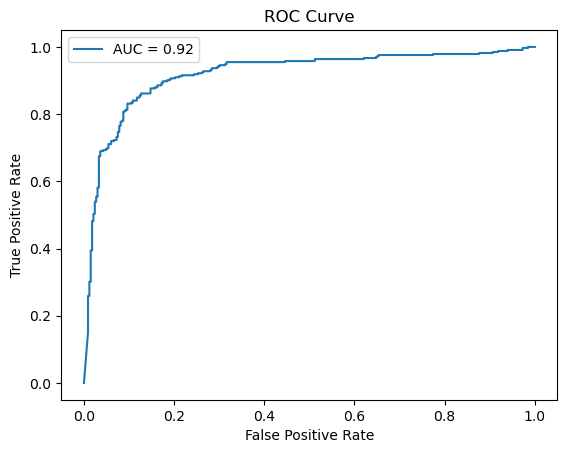

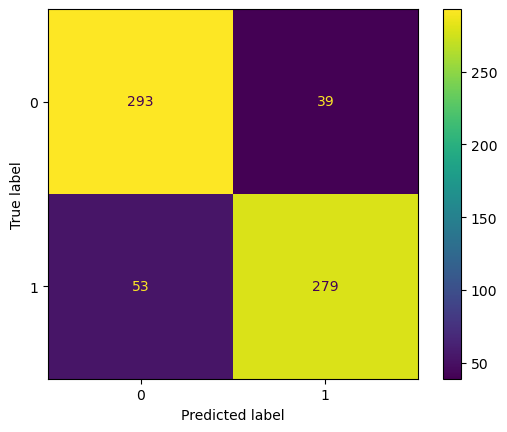

Test loss: 0.8503820300102234
Test Accuracy 0.8614457845687866


In [12]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

loss, accuracy = model.evaluate(X_test, y_test)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)


cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(f'TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')

if len(np.unique(y_test)) == 2:
    auc = roc_auc_score(y_test, y_pred_probs[:, 1])
    print(f'AUC: {auc}')
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs[:, 1])
    import matplotlib.pyplot as plt
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(f'Test loss: {loss}')
print(f'Test Accuracy {accuracy}')